In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import math
import random
from collections import defaultdict
from datetime import datetime, timedelta
from scipy.stats import variation
import sys 
sys.path.append('../Python-modules/') #For bee_helpers and file_helpers 
from file_helpers import create_presence_locations_cam_cache_filename, create_presence_cache_filename, create_presence_locations_cache_filename
from bee_helpers import calc_trip_starts

#from joblib import Parallel, delayed
import multiprocessing
from skimage.filters import threshold_minimum, threshold_mean
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.dummy import DummyClassifier

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from bb_utils.ids import BeesbookID
from bb_utils import meta, ids
#from data_utils.visualization import bivariate_kdeplot
import psycopg2

%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
connect_str = """dbname='beesbook' 
                 user='postgres' 
                 host='tonic.imp.fu-berlin.de' 
                 password='' 
                 application_name='ben_bee_features'"""

In [3]:
from bb_utils import meta
from datetime import timedelta, datetime
from tqdm import tqdm_notebook
from tqdm import tqdm

In [4]:
num_weeks = 8
num_days = 7 * num_weeks
days_after = 7 * 2

group_idx = 25

reference_date = meta.BeeMetaInfo().get_foragergroup(group_idx).date
start_date = reference_date + timedelta(days_after) - timedelta(num_days)
end_date = reference_date + timedelta(days_after)

cache_location_prefix = "../../caches/"
detections_cache_path = cache_location_prefix + "Detections/"
num_days_to_process = 2

assert (end_date < datetime(2016, 9, 19))
assert (start_date > datetime(2016, 7, 19))

start_date, reference_date + timedelta(days_after)

(Timestamp('2016-07-22 00:00:00'), Timestamp('2016-09-16 00:00:00'))

In [5]:
from tqdm import tnrange

In [6]:
def feature_compute_job(day):
    class TrackFeatures:
        def __init__(self, ts_begin, ts_end, confidence=.95, min_track_len=3):
            self.ts_begin = ts_begin
            self.ts_end = ts_end
            self.confidence = confidence
            self.min_track_len = min_track_len
            self.meta = meta.BeeMetaInfo()

            self.exit_positions = {
                0: np.array([6000 - 50, 280]),
                1: np.array([3950, 280]),
                2: np.array([250, 300]),
                3: np.array([6000 - 250, 4000 - 300])
            }

            self.prefix_query = """
            SET geqo_effort to 10;
            SET max_parallel_workers_per_gather TO 8;
            SET temp_buffers to "32GB";
            SET work_mem to "1GB";
            SET temp_tablespaces to "ssdspace";
            """

        @staticmethod
        def process_group(group, min_track_len, exit_positions):
            if len(group) < min_track_len:
                return None

            exit_pos = exit_positions[group.cam_id.unique()[0]]
            group = group.sort_values('timestamp', ascending=True)

            bee_id = group.bee_id.unique()[0]
            dt = group['timestamp'].diff()
            valid = dt.apply(lambda t: t.total_seconds()).values[1:] < (.3 * 2)

            dv = group[['x_pos', 'y_pos']].diff()[1:].apply(
                np.linalg.norm, axis=1).values
            valid = np.logical_and(valid, dv < np.expm1(6))
            dv = dv[valid]
            hd = np.linalg.norm(
                group[['x_pos', 'y_pos']].values - exit_pos[None, :], axis=1)

            return bee_id, dv, hd

        def get_data(self, conn):
            data_query = """
                SELECT q.* 
                FROM (
                    SELECT * from bb_detections_2016_stitched
                    WHERE timestamp >= %s
                        AND timestamp < %s
                        AND bee_id_confidence > %s
                        AND MOD(track_id, 4) = 0
                ) q
                INNER JOIN alive_bees_2016 
                ON (alive_bees_2016.bee_id = q.bee_id) AND
                   (EXTRACT(doy FROM alive_bees_2016.timestamp) = EXTRACT(doy FROM q.timestamp));
            """
            feature_query = """
                SELECT *, oid as combined_id
                INTO TEMPORARY TABLE frame_ids
                FROM matching_frames_2016
                WHERE timestamp_a >= %s
                    AND timestamp_a < %s
                ORDER BY RANDOM() 
                LIMIT 2000;

                SELECT q.*
                INTO TEMPORARY TABLE detections
                FROM (
                    SELECT frame_id, bee_id, x_pos_hive, y_pos_hive, timestamp, cam_id
                    FROM bb_detections_2016_stitched
                    WHERE frame_id in (SELECT frame_id_a FROM frame_ids UNION
                        SELECT frame_id_b FROM frame_ids)
                        AND bee_id_confidence > .95
                ) q
                INNER JOIN alive_bees_2016 
                ON (alive_bees_2016.bee_id = q.bee_id) AND
                   (EXTRACT(doy FROM alive_bees_2016.timestamp) = EXTRACT(doy FROM q.timestamp));

                SELECT * 
                INTO TEMPORARY TABLE detections_with_combined_id
                FROM (
                    SELECT *
                    FROM detections A
                    INNER JOIN frame_ids B ON A.frame_id = B.frame_id_a
                    UNION 
                    SELECT *
                    FROM detections A
                    INNER JOIN frame_ids B ON A.frame_id = B.frame_id_b
                ) q;

                SELECT A.bee_id as bee_id_a,
                    B.bee_id as bee_id_b,
                    (|/((A.x_pos_hive - B.x_pos_hive) ^ 2 + (A.x_pos_hive - B.x_pos_hive) ^ 2)) as distance,
                    A.combined_id as frame_id
                INTO TEMPORARY TABLE distances
                FROM detections_with_combined_id A
                INNER JOIN detections_with_combined_id B
                ON A.combined_id = B.combined_id
                WHERE A.cam_id <> B.cam_id;

                SELECT bee_id_a as bee_id, avg(distance) as avg_distance
                INTO TEMPORARY TABLE avg_distance
                FROM distances
                GROUP BY bee_id_a;

                SELECT bee_id, avg(count) as avg_neighbors_15
                INTO TEMPORARY TABLE avg_neighbors_15
                FROM (
                    SELECT bee_id_a as bee_id, frame_id, count(bee_id_a)
                    FROM distances
                    WHERE distance < 15
                    GROUP BY frame_id, bee_id
                ) q2 GROUP BY bee_id;

                SELECT bee_id, avg(count) as avg_neighbors_30
                INTO TEMPORARY TABLE avg_neighbors_30
                FROM (
                    SELECT bee_id_a as bee_id, frame_id, count(bee_id_a) 
                    FROM distances
                    WHERE distance < 30
                    GROUP BY frame_id, bee_id
                ) q2 GROUP BY bee_id;

                SELECT bee_id, avg(count) as avg_neighbors_50
                INTO TEMPORARY TABLE avg_neighbors_50
                FROM (
                    SELECT bee_id_a as bee_id, frame_id, count(bee_id_a) 
                    FROM distances
                    WHERE distance < 50
                    GROUP BY frame_id, bee_id
                ) q2 GROUP BY bee_id;

                SELECT bee_id_a as bee_id, avg(distance) as avg_distance_queen
                INTO TEMPORARY TABLE avg_distance_queen
                FROM (
                    SELECT * FROM distances
                    WHERE bee_id_b = 1901
                ) query
                GROUP BY bee_id_a;
                
                SELECT q.* 
                INTO TEMPORARY TABLE num_dances_tmp
                FROM (
                    SELECT bee_id, MIN(wdd_dances.timestamp_begin) as timestamp, COUNT(*) as num_dances
                    FROM wdd_dances_to_bb_detections
                    NATURAL JOIN wdd_dances
                    WHERE wdd_dances.valid = True
                        AND timestamp_begin >= %s
                        AND timestamp_end < %s
                    GROUP BY bee_id
                ) q
                INNER JOIN alive_bees_2016 
                ON (alive_bees_2016.bee_id = q.bee_id) AND
                   (EXTRACT(doy FROM alive_bees_2016.timestamp) = EXTRACT(doy FROM q.timestamp));

                SELECT *
                INTO TEMPORARY TABLE results_tmp
                FROM avg_distance
                NATURAL JOIN avg_neighbors_15
                NATURAL JOIN avg_neighbors_30
                NATURAL JOIN avg_neighbors_50
                NATURAL JOIN avg_distance_queen;
                
                SELECT results_tmp.*, coalesce(num_dances_tmp.num_dances, 0) as num_dances
                FROM results_tmp
                LEFT JOIN num_dances_tmp
                ON results_tmp.bee_id = num_dances_tmp.bee_id
                """

            with conn:
                with conn.cursor() as cur:
                    cur.execute(self.prefix_query)
                    self.data = pd.read_sql_query(
                        data_query,
                        conn,
                        params=(self.ts_begin, self.ts_end, self.confidence),
                        coerce_float=False)
                    self.sql_features = pd.read_sql_query(
                        feature_query,
                        conn,
                        coerce_float=False,
                        params=(self.ts_begin, self.ts_end, self.ts_begin, self.ts_end))
                    self.sql_features['Age'] = [
                        self.meta.get_age(
                            BeesbookID.from_ferwar(k),
                            datetime.combine(self.ts_begin.date(),
                                             datetime.min.time())).days
                        for k in self.sql_features.bee_id.values
                    ]

        def get_features(self):
            assert self.data is not None

            df_grouped = self.data.groupby('track_id')

            dvs = defaultdict(list)
            hds = defaultdict(list)

            results = [TrackFeatures.process_group(group, self.min_track_len, self.exit_positions) for name, group in df_grouped]
            for res in results:
                if res is not None:
                    bee_id, dv, hd = res

                    dvs[bee_id].append(dv)
                    hds[bee_id].append(hd)

            self.dvs = dict(
                [(k, np.concatenate(v))
                 for k, v in sorted(dvs.items(), key=lambda kv: kv[0])])
            self.hds = dict(
                [(k, np.concatenate(v))
                 for k, v in sorted(hds.items(), key=lambda kv: kv[0])])
            self.ages = [
                self.meta.get_age(
                    BeesbookID.from_ferwar(k),
                    datetime.combine(self.ts_begin.date(),
                                     datetime.min.time())).days
                for k, v in sorted(dvs.items(), key=lambda kv: kv[0])
            ]
            self.ids = [k for k, v in sorted(dvs.items(), key=lambda kv: kv[0])]

            movement_threshold = 5

            dvs_mean = [
                np.mean(v[v > movement_threshold])
                for k, v in sorted(self.dvs.items(), key=lambda kv: kv[0])
            ]
            dvs_median = [
                np.median(v[v > movement_threshold])
                for k, v in sorted(self.dvs.items(), key=lambda kv: kv[0])
            ]

            mean_activity = [
                np.mean(v > movement_threshold)
                for k, v in sorted(self.dvs.items(), key=lambda kv: kv[0])
            ]
            total_distance = [
                np.sum(v[v > movement_threshold])
                for k, v in sorted(self.dvs.items(), key=lambda kv: kv[0])
            ]
            exit_distance = [
                np.mean(v)
                for k, v in sorted(self.hds.items(), key=lambda kv: kv[0])
            ]
            time_visible = np.array([
                len(v) for k, v in sorted(self.hds.items(), key=lambda kv: kv[0])
            ])
            time_visible = time_visible / \
                np.max(time_visible[~np.isnan(time_visible)])

            self.features = pd.DataFrame(
                np.stack([
                    self.ids,
                    self.ages,
                    dvs_mean,
                    # dvs_median,
                    mean_activity,
                    total_distance,
                    exit_distance,
                    time_visible
                ]).T,
                columns=[
                    'bee_id',
                    'Age',
                    'Mean movement speed',
                    #'Median movement speed',
                    'Mean activity',
                    'Total movement distance',
                    'Mean hive exit distance',
                    'Proportion of time visible'
                ])

            self.features = pd.merge(
                self.features, self.sql_features, on=['bee_id', 'Age'])

            self.features = self.features.astype(np.float64)
            self.features = self.features.loc[np.sum(
                np.isnan(self.features.values), axis=1) == 0]
        
    tfeatures = TrackFeatures(
        ts_start + timedelta(days=day),
        ts_end + timedelta(days=day),
        confidence)

    with psycopg2.connect(connect_str) as conn:
        tfeatures.get_data(conn)

    tfeatures.get_features()
    
    return tfeatures.features

In [7]:
ts_start = start_date + timedelta(hours=12)
dt = timedelta(hours=2)
ts_end = ts_start + dt
confidence = .95

In [8]:
from tqdm import tnrange

In [9]:
import time

In [10]:
print((reference_date - start_date).days)

42


In [ ]:
features = []
feature_futures = []
days_skipped = [0,0]
days_skipped[0] = 0
days_skipped[1] = 0
for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days)): #(reference_date + timedelta(days_after) - start_date).days
    try:
        feature_futures.append(feature_compute_job(day)) #(reference_date - start_date).days)
    except ValueError:
        days_skipped[0] += 1
        pass


  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
### getting 2nd set of data for nighttimes
ts_start = start_date
dt = timedelta(hours=2)
ts_end = ts_start + dt
confidence = .95

In [ ]:
for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days)): #(reference_date + timedelta(days_after) - start_date).days
    try:
        feature_futures.append(feature_compute_job(day)) #(reference_date - start_date).days)
    except ValueError:
        days_skipped[1] += 1
        pass

In [ ]:
print(days_skipped[0], days_skipped[1])

In [ ]:
features = [feature_futures]

In [ ]:
class DummyFeatures:
    def __init__(self):
        None
        
tfeatures = DummyFeatures()
tfeatures_2 = DummyFeatures()

In [ ]:
tfeatures.features = pd.DataFrame(feature_futures[0])
tfeatures_2.features = pd.DataFrame(feature_futures[0])

In [ ]:
last_alive_path = detections_cache_path+'Last_day_alive.csv'
last_day_alive_df = pd.read_csv(last_alive_path, 
                           parse_dates=['max'], 
                           usecols=['max', 'bee_id'])

last_day_alive_df = last_day_alive_df.loc[last_day_alive_df['max'] >= datetime(2016, 7, 20+num_days_to_process)]
last_day_alive_df.index = last_day_alive_df['bee_id']

In [ ]:
# Todo:
def calculate_x_y_averages(day):
#load presence_locations
    (csv_name, csv_path) = create_presence_locations_cache_filename(24, day, 60)
    print('loading '+csv_path)
    presence_locations_df = pd.read_csv(csv_path, dtype=object).iloc[:,1:]
    (csv_name, csv_path) = create_presence_cache_filename(24, day, 60)
    print('loading '+csv_path)
    presence_df = pd.read_csv(csv_path).iloc[:,1:]
#calculate trip starts
    #Preparing for rolling median
    num_nans_to_clean = math.floor(5/2)
    #apply copies of the first and last column as offset to prepare for the rolling window
    first_col = presence_df.iloc[:, 1:2]
    last_col = presence_df.iloc[:, -1:]
    presence_df_with_offset = presence_df.iloc[:, 1:]
    for i in range(0,num_nans_to_clean):
        presence_df_with_offset = pd.concat([first_col, presence_df_with_offset, last_col] ,axis=1)
    # Applying rolling median window, to filter out noise in the dataframe
    rolled = presence_df_with_offset.rolling(window=5,center=True,axis=1).median()
    #clean up to get rid of the NaNs
    rolled = rolled.iloc[:, num_nans_to_clean:-num_nans_to_clean]
    
    trip_starts = calc_trip_starts(rolled, 1440)
#create dataframes with avrg x and y coordinates
    loc_x_df = presence_locations_df.copy()
    loc_x_df.loc[:,:] = 0.0
    loc_y_df = presence_locations_df.copy()
    loc_y_df.loc[:,:] = 0.0
    for i in range(len(trip_starts)):
        for j in range(len(trip_starts[i])):
            #print(i, trip_starts[i][j],  end=' ')
            if presence_locations_df.iat[i,trip_starts[i][j]] != "0.0" and "," in presence_locations_df.iat[i,trip_starts[i][j]]:
                temp=presence_locations_df.iat[i,trip_starts[i][j]]
                coordinates=[int(s) for s in temp.replace("(","").replace(")","").replace(",","").replace("-","").split() if s.isdigit()]
                loc_x_df.iat[i,trip_starts[i][j]] = coordinates[0]
                loc_y_df.iat[i,trip_starts[i][j]] = coordinates[1]
    return(loc_x_df.replace(0,np.NaN).mean(axis=1), loc_y_df.replace(0,np.NaN).mean(axis=1))
#attach them

In [ ]:
feature_futures_dead = []
feature_futures_alive = []
for i in range(2):
    for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days - days_skipped[i])): #(reference_date + timedelta(days_after) - start_date).days) , 
        avrg_x_df, avrg_y_df = calculate_x_y_averages(start_date + timedelta(days=day))
        features_df = pd.DataFrame(feature_futures[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i])
        for bee_id in features_df.bee_id:
            features_df.loc[features_df['bee_id'] == bee_id, 'average_x_coordinate'] = avrg_x_df[bee_id]
            features_df.loc[features_df['bee_id'] == bee_id, 'average_y_coordinate'] = avrg_y_df[bee_id]
        features_df['daytime'] = i
        feature_futures_dead.append(features_df)
        feature_futures_alive.append(features_df)
        for id in last_day_alive_df.index:
            last_day = last_day_alive_df.loc[id][1]
            if not (last_day > (start_date + timedelta(days=day)) and (last_day <= (start_date + timedelta(days=day) + timedelta(days=num_days_to_process)))):
                feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i] = feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i][feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i].bee_id !=id]
            elif last_day == (start_date + timedelta(days=day)):
                feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i] = feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i][feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i].bee_id !=id]
                feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i] = feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i][feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i].bee_id !=id]
            else:
                feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i] = feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i][feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i].bee_id !=id]

In [ ]:
print(features_df)

In [ ]:
tfeatures.features = pd.concat([pd.DataFrame(feature_futures_dead[0]), pd.DataFrame(feature_futures_dead[1])], ignore_index=True)
tfeatures_2.features = pd.concat([pd.DataFrame(feature_futures_alive[0]), pd.DataFrame(feature_futures_alive[1])], ignore_index=True)

In [ ]:
for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days - 2 - days_skipped[0] + (reference_date + timedelta(days_after) - start_date).days - days_skipped[1])):
    tfeatures.features = pd.concat([tfeatures.features, pd.DataFrame(feature_futures_dead[day+2])], ignore_index=True)

In [ ]:
for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days - 2 - days_skipped[0] + (reference_date + timedelta(days_after) - start_date).days - days_skipped[1])):
    tfeatures_2.features = pd.concat([tfeatures_2.features, pd.DataFrame(feature_futures_alive[day+2])], ignore_index=True)

In [ ]:
tfeatures.features.sort_values(by=['bee_id'])
#tfeatures.features = tfeatures.features.groupby(['bee_id'], as_index=False, sort=False).mean()

In [ ]:
tfeatures_2.features.sort_values(by=['bee_id'])
#tfeatures_2.features = tfeatures_2.features.groupby(['bee_id'],as_index=False, sort=False).mean()

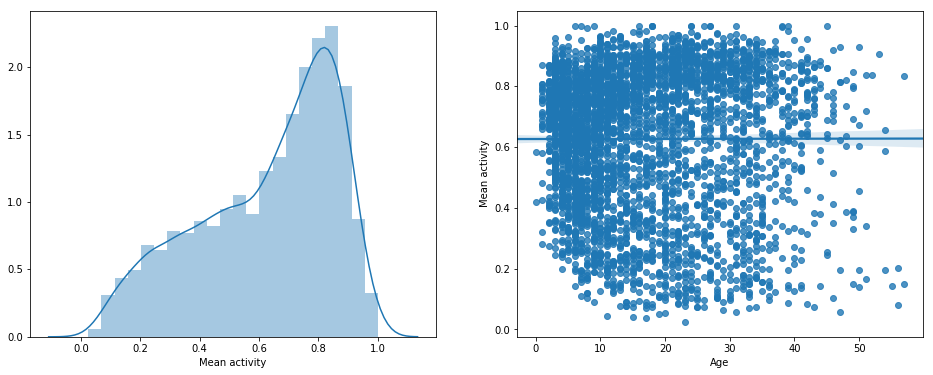

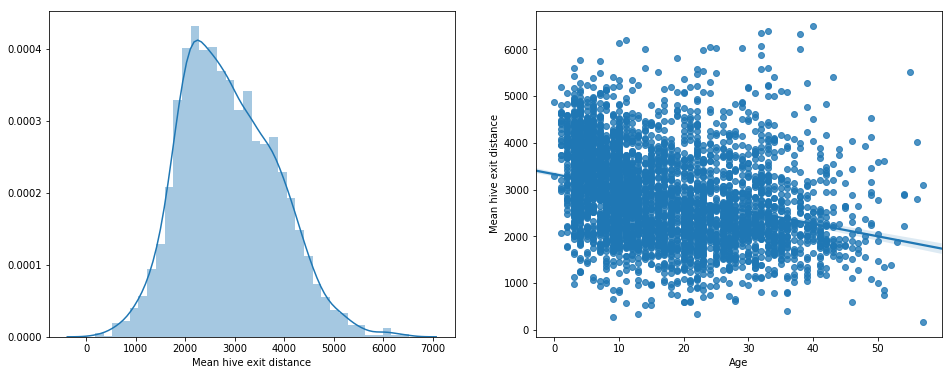

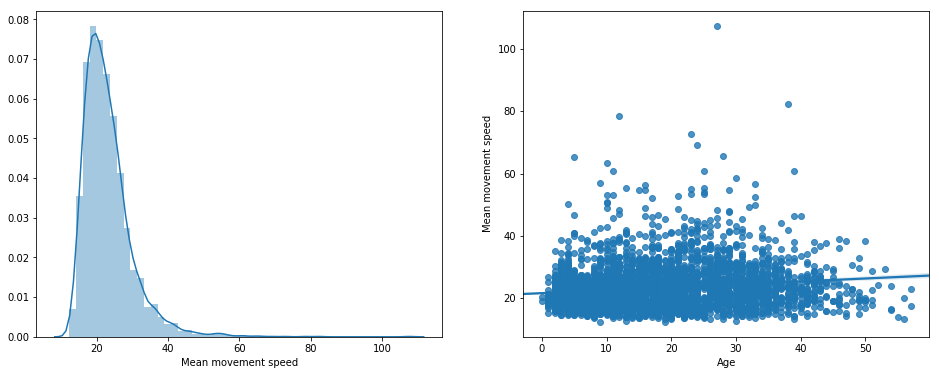

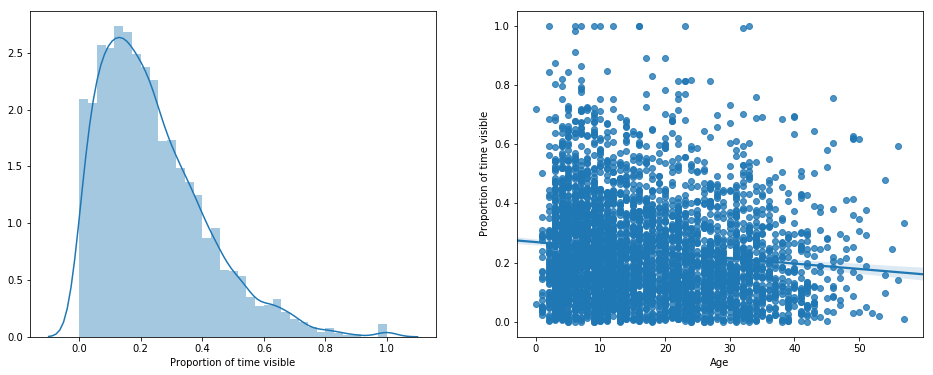

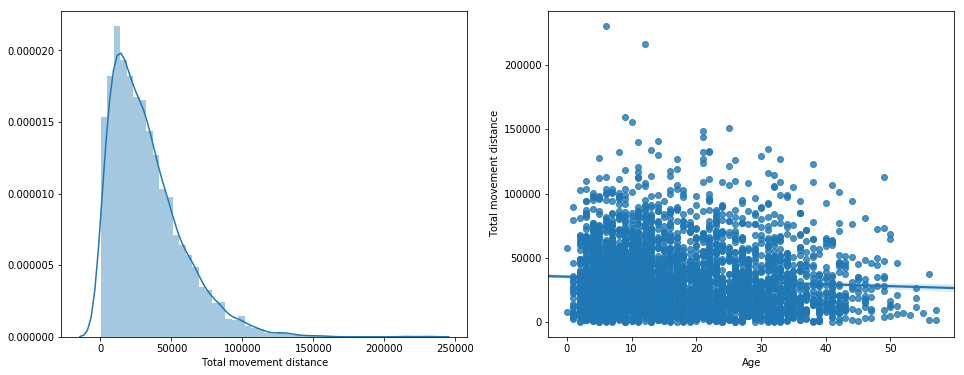

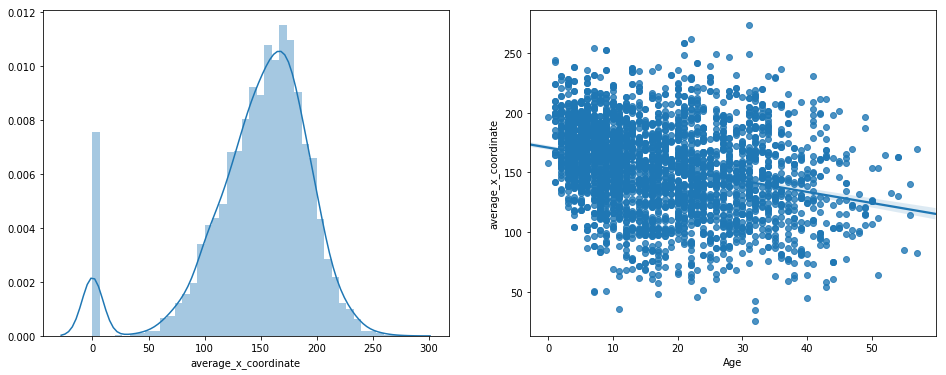

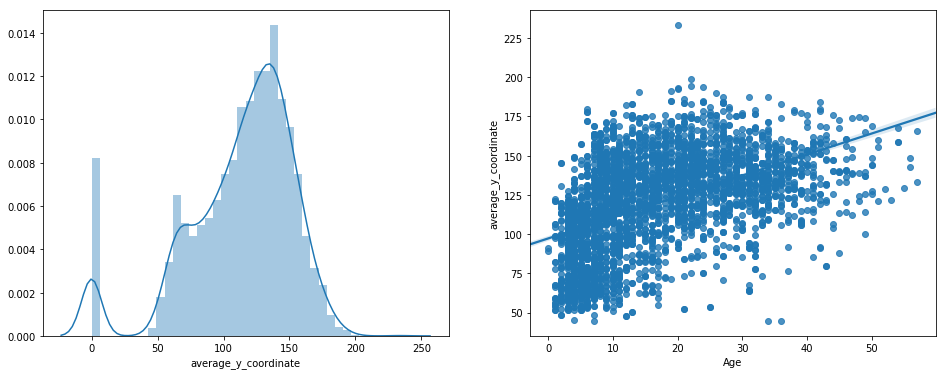

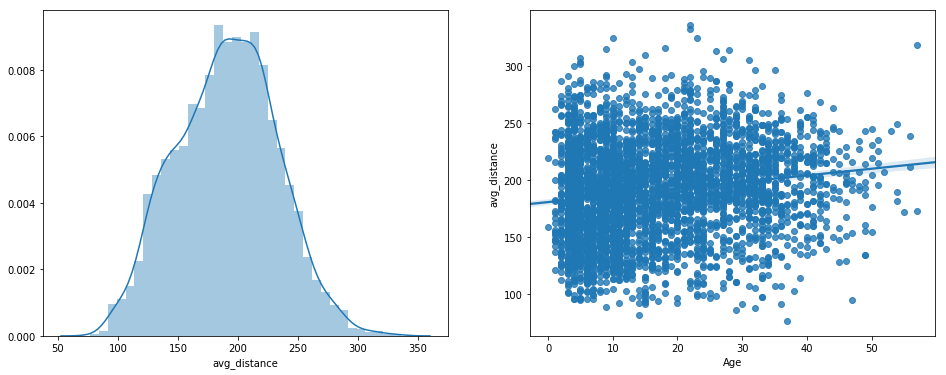

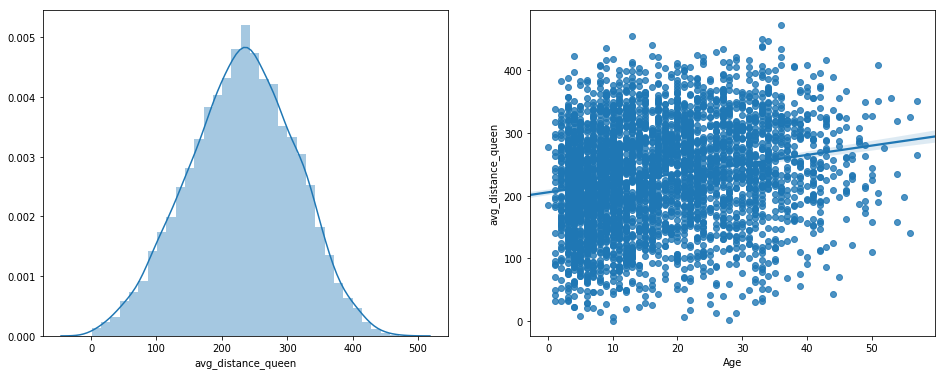

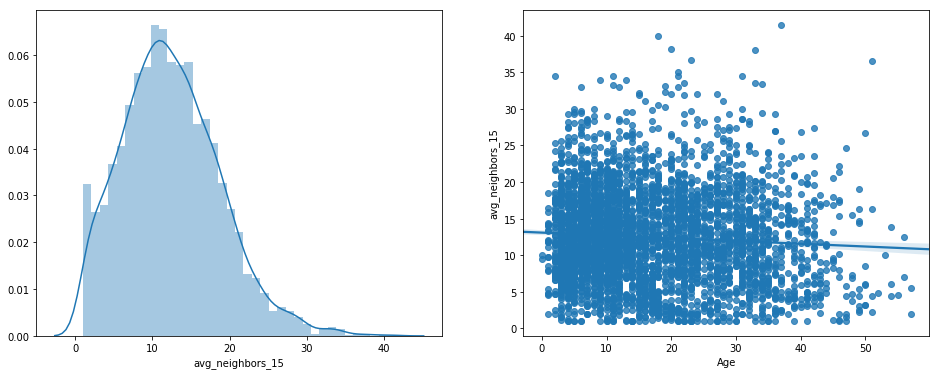

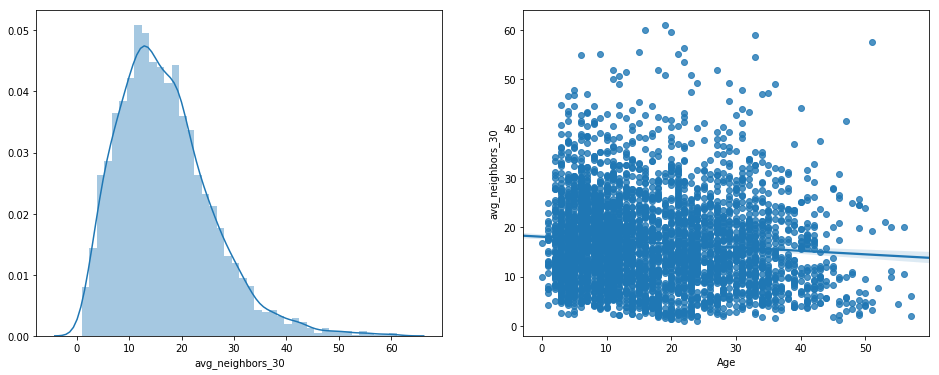

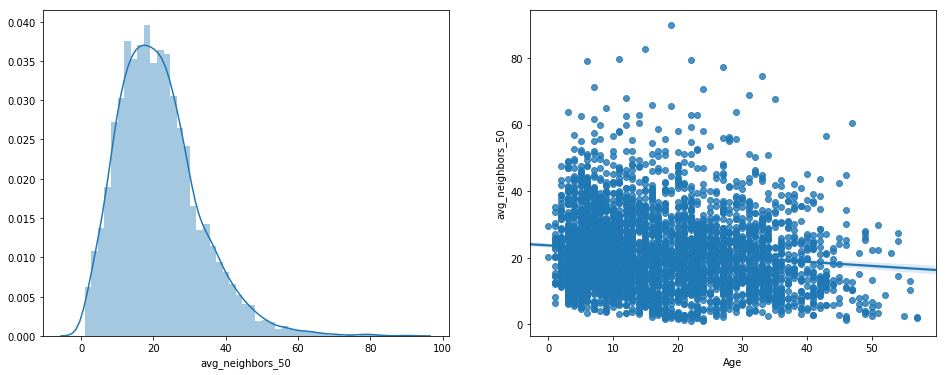

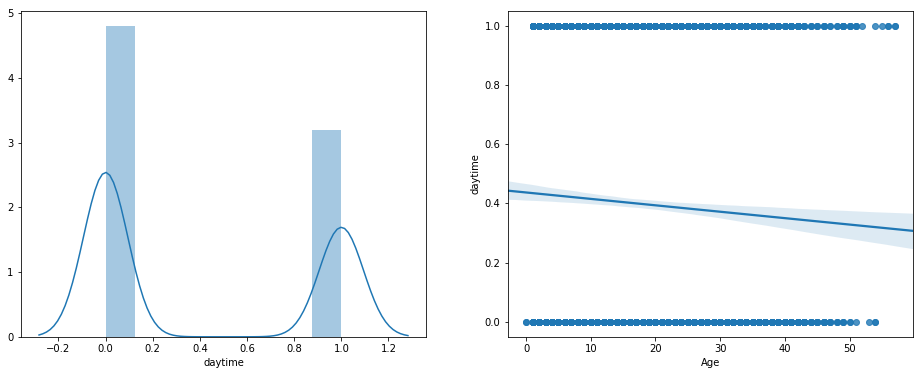

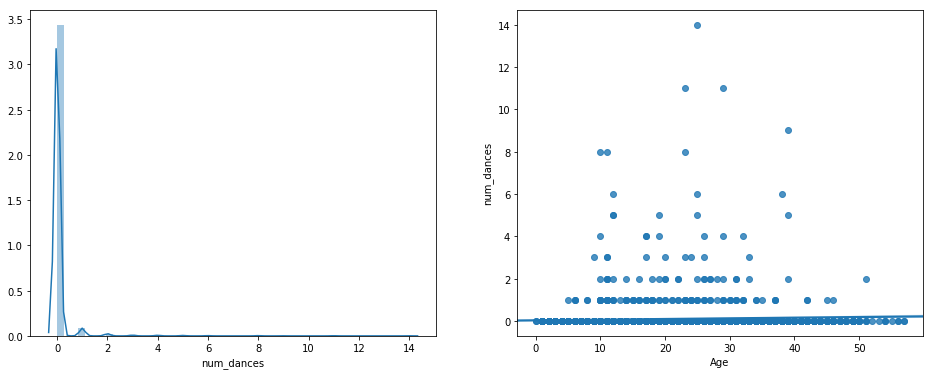

In [63]:
for feature in tfeatures.features.columns:
    if feature in ('bee_id', 'Age', 'day'):
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.distplot(tfeatures.features[feature].fillna(0), ax=axes[0])
    sns.regplot('Age', feature, tfeatures.features, ax=axes[1])

In [ ]:
for feature in tfeatures_2.features.columns:
    if feature in ('bee_id', 'Age', 'day'):
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.distplot(tfeatures_2.features[feature].fillna(0), ax=axes[0])
    sns.regplot('Age', feature, tfeatures_2.features, ax=axes[1])

In [ ]:
dead_data_df = tfeatures.features.copy()
dead_data_df['dies'] = 1
dead_data_df = dead_data_df.drop(['bee_id'], axis=1)
alive_data_df = tfeatures_2.features.copy()
alive_data_df['dies'] = 0
alive_data_df = alive_data_df.drop(['bee_id'], axis=1)

In [ ]:
dead_data_df = dead_data_df.sample(frac=1).reset_index(drop=True)
alive_data_df = alive_data_df.sample(frac=1).reset_index(drop=True)

#undersampling part
dying_samples = dead_data_df.shape[0]
alive_indices = alive_data_df[alive_data_df.dies == 0].index
random_ratio = random.uniform(2, 4)
random_indices = np.random.choice(alive_indices, dying_samples, replace=False) #int(np.floor(dying_samples*random_ratio))
ratio = np.ceil(alive_data_df.shape[0] / dying_samples)

trainingsdataset = pd.concat([dead_data_df, alive_data_df.loc[random_indices]], ignore_index=True) #.loc[random_indices]
print(trainingsdataset.shape)

In [ ]:
trainingsdataset = trainingsdataset.sample(frac=1).reset_index(drop=True)
trainingsdataset.head(20)

In [ ]:
target = trainingsdataset['dies'].copy()
data = trainingsdataset.drop(['dies'], axis=1)

In [48]:
training_data, test_data, training_target, test_target = train_test_split(data, target, test_size=0.25)
#test_data = pd.concat([test_data, alive_data_df.loc[2296:].drop(['dies'], axis=1)])
#print(test_target.shape)
#test_target = pd.concat([test_target, alive_data_df.loc[2296:]['dies']], ignore_index=True)
#print(test_target.shape)

#sample_weight = np.array([ratio if i == 0 else 1 for i in training_target])
#print(sample_weight)

In [49]:
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
imp = imp.fit(training_data)

training_data_imp = imp.transform(training_data)
test_data = imp.transform(test_data)

dummy = DummyClassifier(strategy='uniform',random_state=0)
dct = DecisionTreeClassifier(max_features=3, max_depth=None, min_samples_split=2, random_state=0, class_weight='balanced')
etc = ExtraTreesClassifier(n_estimators=1000, max_features=None, max_depth=None, min_samples_split=2, random_state=0, class_weight='balanced_subsample')
rfc = RandomForestClassifier(n_estimators=1000, max_features=None, max_depth=None, min_samples_split=2, random_state=0, class_weight='balanced_subsample')
ada = AdaBoostClassifier(n_estimators=1000, base_estimator=rfc)
#gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
gbc = GradientBoostingClassifier(n_estimators= 1000, max_leaf_nodes= 4, max_depth= None, random_state= 2, min_samples_split= 5)
nc = NearestCentroid()
qda = QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False,
                              store_covariances=None, tol=0.0001)

dummy=dummy.fit(training_data_imp, training_target)
dct=dct.fit(training_data_imp, training_target)
etc=etc.fit(training_data_imp, training_target)
rfc=rfc.fit(training_data_imp, training_target)
ada=ada.fit(training_data_imp, training_target)
#gbr=gbr.fit(training_data_imp, training_target)
gbc = gbc.fit(training_data_imp, training_target)
nc = nc.fit(training_data_imp, training_target)
qda = qda.fit(training_data_imp, training_target)

In [50]:
print(dummy.score(test_data, test_target))
print(dct.score(test_data, test_target))
print(etc.score(test_data, test_target))
print(rfc.score(test_data, test_target))
print(ada.score(test_data, test_target))
#print(gbr.score(test_data, test_target))
print(gbc.score(test_data, test_target))

0.4813256180957391
0.5733824302998421
0.6738558653340347
0.6675433982114677
0.6664913203577064
0.6586007364544977


In [51]:
print(dummy.predict(test_data).sum())
print(dct.predict(test_data).sum())
print(etc.predict(test_data).sum())
print(rfc.predict(test_data).sum())
print(ada.predict(test_data).sum())
#print(gbr.predict(test_data).sum())
print(gbc.predict(test_data).sum())

966
955
994
1028
1030
975


In [52]:
scores = cross_val_score(dummy, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, dummy.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, dummy.predict(test_data))))

cross_val_scores:0.49765505430530066
mean_squared_error:0.518674381904261
f1_score:0.47995780590717296


cross_val_scores:0.5558217465340909
mean_squared_error:0.4266175697001578
f1_score:0.5697612732095491


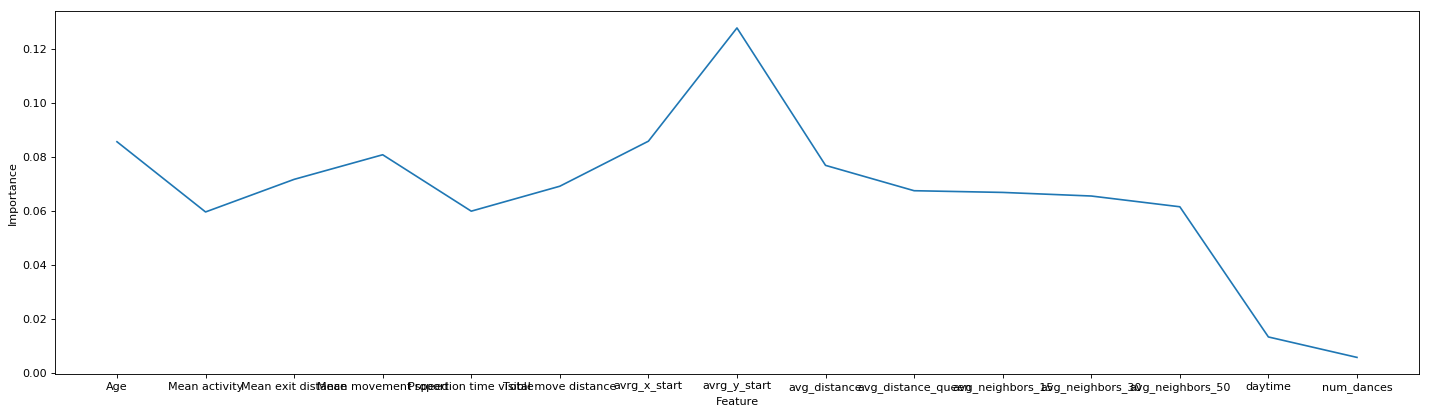

In [53]:
scores = cross_val_score(dct, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, dct.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, dct.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(dct.feature_importances_)
plt.show()

cross_val_scores:0.6359531566601134
mean_squared_error:0.32614413466596526
f1_score:0.6777546777546777


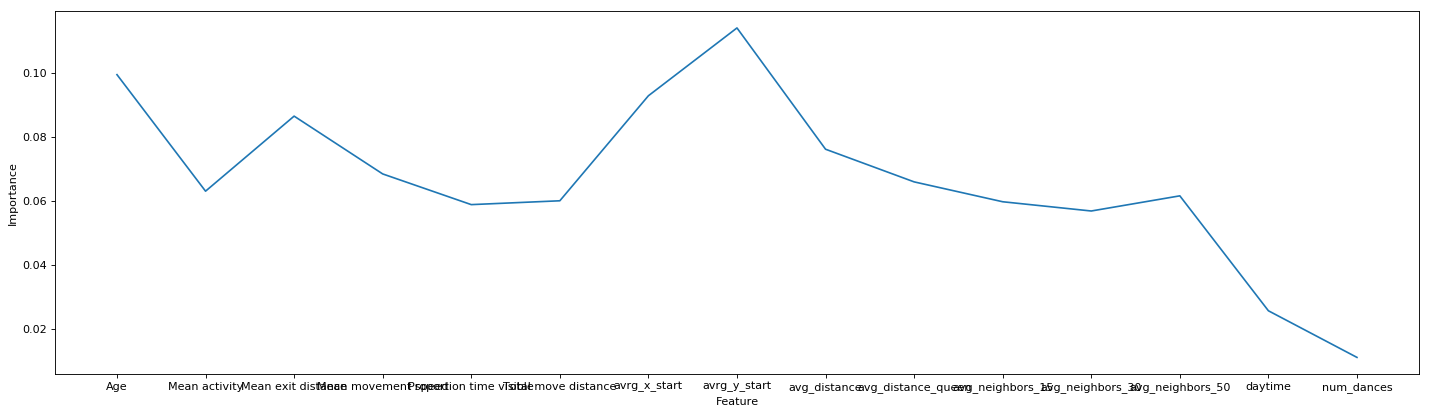

In [54]:
scores = cross_val_score(etc, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, etc.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, etc.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(etc.feature_importances_)
plt.show()

cross_val_scores:0.6419225697475425
mean_squared_error:0.33245660178853237
f1_score:0.6772216547497447


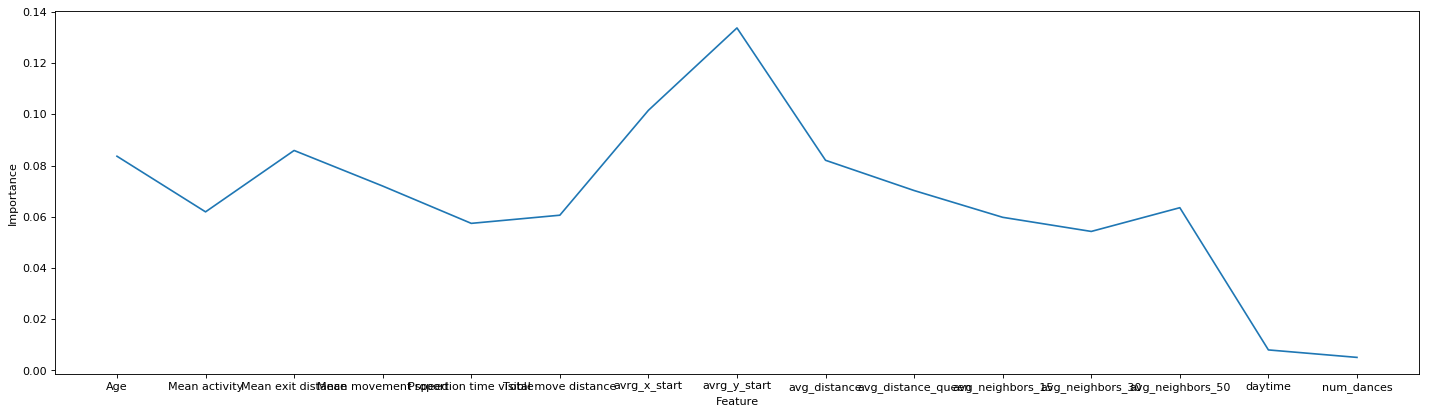

In [55]:
scores = cross_val_score(rfc, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, rfc.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, rfc.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(rfc.feature_importances_)
plt.show()

cross_val_scores:0.6325581313947227
mean_squared_error:0.3335086796422935
f1_score:0.676530612244898


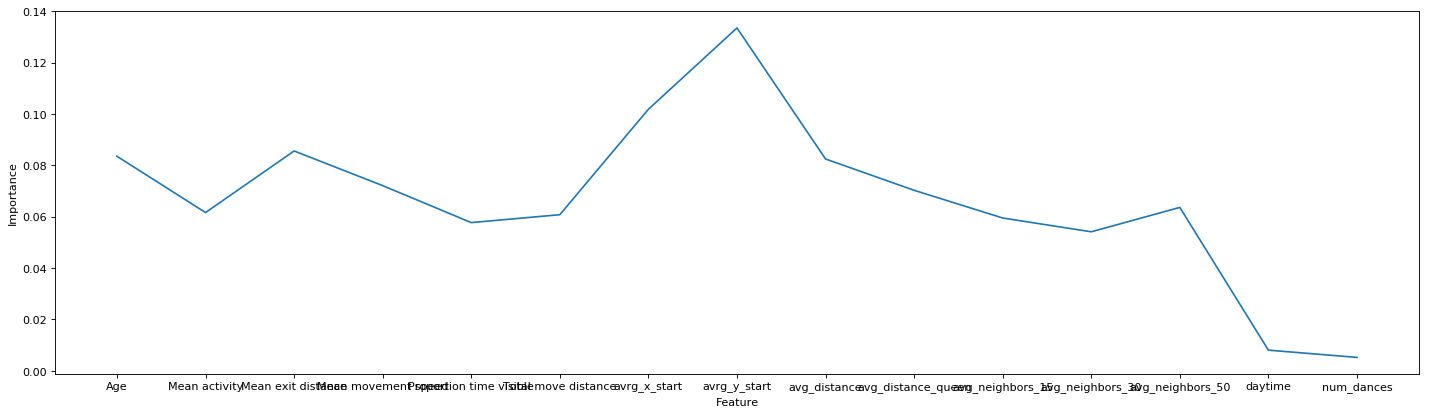

In [56]:
scores = cross_val_score(ada, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, ada.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, ada.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(ada.feature_importances_)
plt.show()

In [57]:
#scores = cross_val_score(gbr, test_data, test_target, scoring='f1')
#print('cross_val_scores:' + str(scores.mean()))
#print('feature_importances:' + str(gbr.feature_importances_))
#print('mean_squared_error:' + str(mean_squared_error(test_target, gbr.predict(test_data))))

#plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.xlabel('Feature')
#plt.ylabel('Importance')
#plt.xticks(np.arange(14), ('Age', 'Mean movement speed', 'Mean activity','Total move distance', 'Mean exit distance', 'Proportion time visible', 'avg_distance', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'avg_distance_queen', 'num_dances', 'avrg_x_start', 'avrg_y_start'))
#plt.plot(gbr.feature_importances_)
#plt.show()

In [58]:
scores = cross_val_score(nc, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, nc.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, nc.predict(test_data))))

cross_val_scores:0.5675335751321937
mean_squared_error:0.46975276170436614
f1_score:0.5654501216545013


In [59]:
scores = cross_val_score(qda, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, qda.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, qda.predict(test_data))))

cross_val_scores:0.4852743512175994
mean_squared_error:0.34823776959495
f1_score:0.6452304394426581


cross_val_scores:0.6104524930028727
mean_squared_error:0.3413992635455024
f1_score:0.6593175853018373


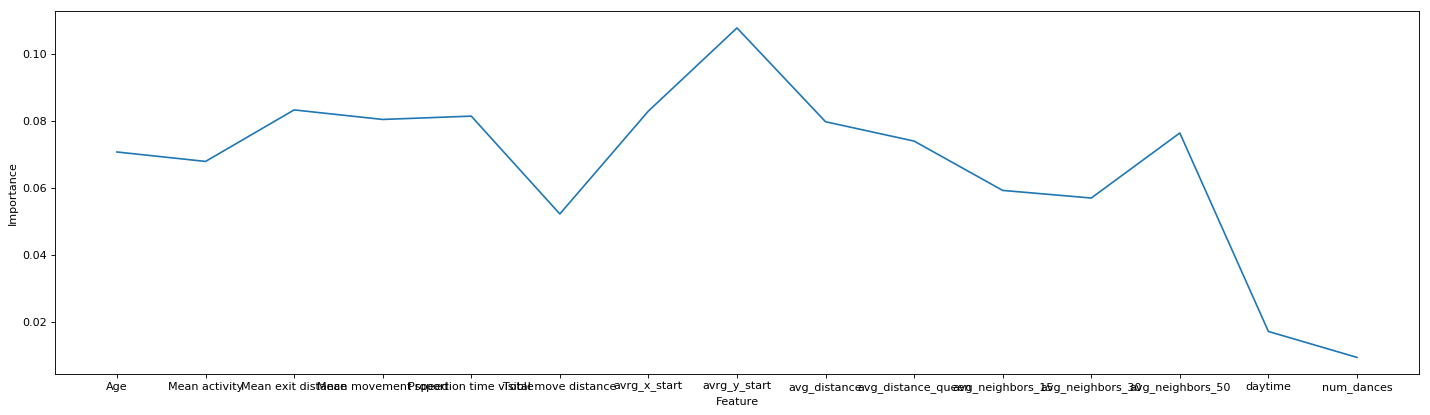

In [60]:
scores = cross_val_score(gbc, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, gbc.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, gbc.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(gbc.feature_importances_)
plt.show()

In [61]:
print(test_target.shape)
print(test_target.sum())

(1901,)
930


In [62]:
print(days_skipped)

[2, 1]


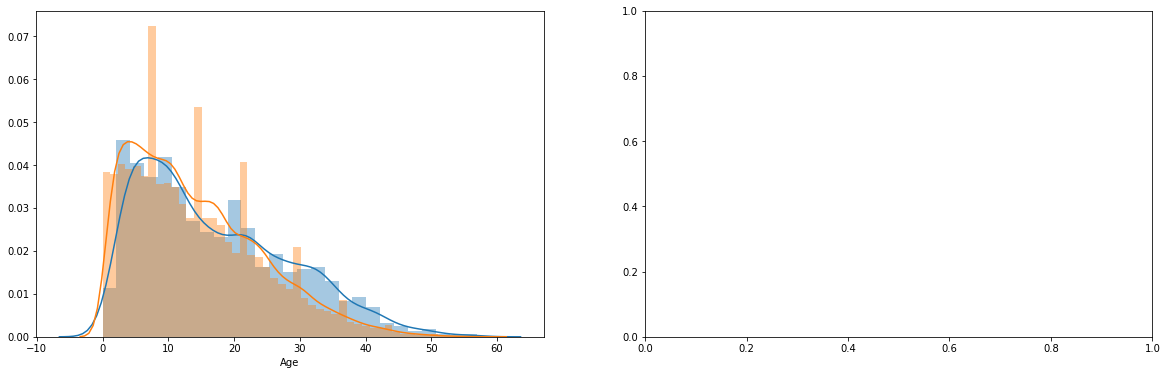

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.distplot(tfeatures.features['Age'].fillna(0), ax=axes[0])
sns.distplot(tfeatures_2.features['Age'].fillna(0), ax=axes[0])